### Setup

In [7]:
import numpy as np
import epios
from scipy.interpolate import interp1d, make_interp_spline
import matplotlib.pyplot as plt
import pandas as pd
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import stan
import arviz as az
import nest_asyncio
nest_asyncio.apply()

### Do sampling

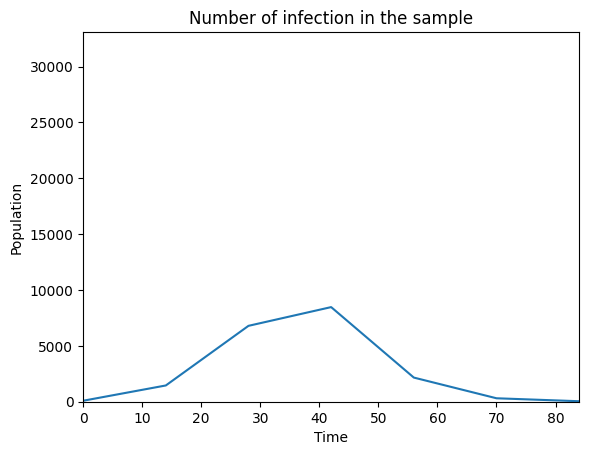

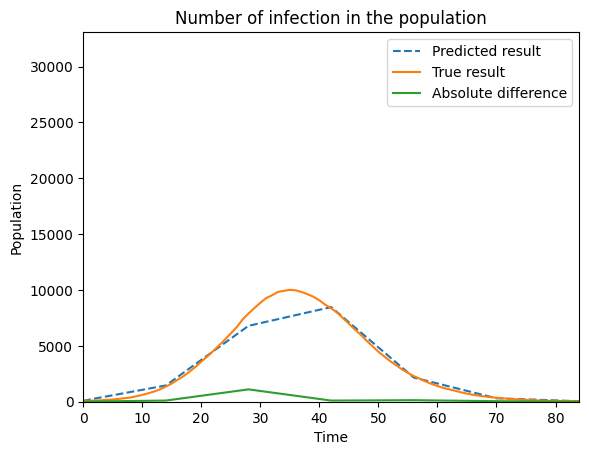

In [8]:
demo_data = pd.read_csv('./demographics_large.csv')
time_data = pd.read_csv('./inf_status_history_large.csv')

# Define the class instance
postprocess = epios.PostProcess(time_data=time_data, demo_data=demo_data)
time_sample=[0, 14, 28, 42, 56, 70, 84]

# Do prediction and comparison based age-region stratification
result, diff = postprocess.predict.Base(sample_size=750,
                                             time_sample=time_sample,
                                             comparison=True,
                                            #  non_responder=False,
                                             gen_plot=True,
                                             sample_strategy='Random')

### Interpolation

In [3]:
# This has the true result
true_result_plot = []
for t in range(max(time_sample) + 1):
    num = time_data.iloc[t, 1:].value_counts().get(3, 0)
    num += time_data.iloc[t, 1:].value_counts().get(4, 0)
    num += time_data.iloc[t, 1:].value_counts().get(5, 0)
    num += time_data.iloc[t, 1:].value_counts().get(6, 0)
    num += time_data.iloc[t, 1:].value_counts().get(7, 0)
    num += time_data.iloc[t, 1:].value_counts().get(8, 0)
    true_result_plot.append(num)

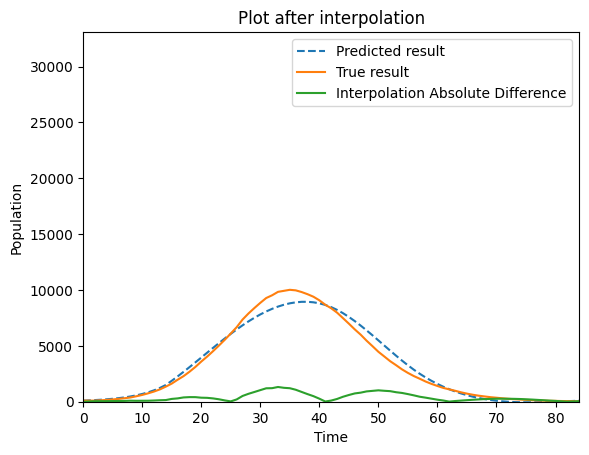

Spline Absolute Difference is 32697.99583686032
Spline Absolute Max is 1318.7580760620567


In [4]:
# Spline Interpolation
result_scaled = np.round(np.array(result[1]) * len(demo_data))
cubic_interp = interp1d(time_sample, result_scaled, kind='cubic')
y_interpolated = cubic_interp(range(max(time_sample) + 1))
x1 = time_sample[0]
x2 = time_sample[1]
y1 = true_result_plot[0]
y2 = result_scaled[1]
c = (np.log(y2) - np.log(y1)) / (x2 - x1)
A = y1 * np.exp(c * x1)
def exp_interpolation(x, A, c):
    return A * np.exp(c * x)
y_interpolated[0:time_sample[1]] = exp_interpolation(range(time_sample[1]), A, c)
diff_interp = np.abs(np.array(true_result_plot) - y_interpolated)
plt.figure()
plt.plot(range(max(time_sample) + 1), y_interpolated, label='Predicted result', linestyle='--')
plt.plot(range(max(time_sample) + 1), true_result_plot, label='True result')
plt.plot(range(max(time_sample) + 1), diff_interp, label='Interpolation Absolute Difference')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.xlim(0, max(time_sample))
plt.ylim(0, len(demo_data))
plt.title('Plot after interpolation')
plt.show()
score_spline_14days = np.sum(diff_interp)
max_spline_14days = max(diff_interp)
print('Spline Absolute Difference is', score_spline_14days)
print('Spline Absolute Max is', max_spline_14days)

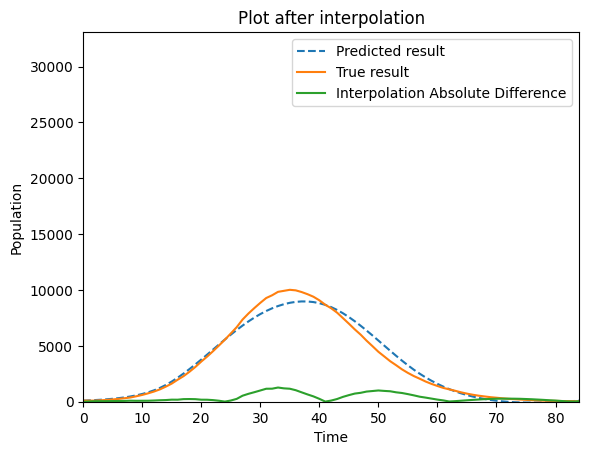

B-Spline Absolute Difference is 31100.20709208653
B-Spline Absolute Max is 1269.8802702399644


In [5]:
# B-Spline Interpolation
k = 3 # Degree of the spline
result_scaled = np.round(np.array(result[1]) * len(demo_data))
spline = make_interp_spline(time_sample, result_scaled, k=k, bc_type='natural')  # Natural boundary conditions
y_interpolated = spline(range(max(time_sample) + 1))
x1 = time_sample[0]
x2 = time_sample[1]
y1 = true_result_plot[0]
y2 = result_scaled[1]
c = (np.log(y2) - np.log(y1)) / (x2 - x1)
A = y1 * np.exp(c * x1)
def exp_interpolation(x, A, c):
    return A * np.exp(c * x)
y_interpolated[0:time_sample[1]] = exp_interpolation(range(time_sample[1]), A, c)
diff_interp = np.abs(np.array(true_result_plot) - y_interpolated)
plt.figure()
plt.plot(range(max(time_sample) + 1), y_interpolated, label='Predicted result', linestyle='--')
plt.plot(range(max(time_sample) + 1), true_result_plot, label='True result')
plt.plot(range(max(time_sample) + 1), diff_interp, label='Interpolation Absolute Difference')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.xlim(0, max(time_sample))
plt.ylim(0, len(demo_data))
plt.title('Plot after interpolation')
plt.show()
score_bspline_14days = np.sum(diff_interp)
max_bspline_14days = max(diff_interp)
print('B-Spline Absolute Difference is', score_bspline_14days)
print('B-Spline Absolute Max is', max_bspline_14days)

### Interpolation Performance

In [6]:
# See file ./limited_resources_parallel_comp.py

Results: 

Mean score of Spline is 38061.23007317914

Max of Spline is 2175.7173052894623

Mean score of B-Spline is 25991.39686769734

Max of B-Spline is 2023.1576923076937

Mean score of Spline is 27115.030152628384

Max of Spline is 2694.4833090012908

Mean score of B-Spline is 26482.946818767054

Max of B-Spline is 2694.8186526505397

Summary: In general, these interpolation seems to perform not bad. The B-Spline method performs better than the Spline method. However, one possible reason is that the B-Spline method assumes `natural` boundary conditions, which is to assume zero derivative at boundaries. This assumption might not be true when the infection curve does not start at 0 and end at 0.

### Calculate $R_t$

In [11]:
# Prepare the data used
# This has the true result
true_result_plot = []
for t in range(max(time_sample) + 1):
    num = time_data.iloc[t, 1:].value_counts().get(3, 0)
    num += time_data.iloc[t, 1:].value_counts().get(4, 0)
    num += time_data.iloc[t, 1:].value_counts().get(5, 0)
    num += time_data.iloc[t, 1:].value_counts().get(6, 0)
    num += time_data.iloc[t, 1:].value_counts().get(7, 0)
    num += time_data.iloc[t, 1:].value_counts().get(8, 0)
    true_result_plot.append(num)
# result_scaled = np.round(np.array(result[1]) * len(demo_data))
k = 3 # Degree of the spline
spline = make_interp_spline(time_sample, result[1], k=k, bc_type='natural')  # Natural boundary conditions
y_interpolated = spline(range(max(time_sample) + 1))
x1 = time_sample[0]
x2 = time_sample[1]
y1 = true_result_plot[0] / len(demo_data)
y2 = result[1][1]
c = (np.log(y2) - np.log(y1)) / (x2 - x1)
A = y1 * np.exp(c * x1)
def exp_interpolation(x, A, c):
    return A * np.exp(c * x)
y_interpolated[0:time_sample[1]] = exp_interpolation(range(time_sample[1]), A, c)
diff_interp = np.abs(np.array(true_result_plot) - y_interpolated)
# plt.figure()
# plt.plot(range(max(time_sample) + 1), y_interpolated, label='Predicted result', linestyle='--')
# plt.plot(range(max(time_sample) + 1), true_result_plot, label='True result')
# plt.plot(range(max(time_sample) + 1), diff_interp, label='Interpolation Absolute Difference')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Population')
# plt.xlim(0, max(time_sample))
# plt.ylim(0, len(demo_data))
# plt.title('Plot after interpolation')
# plt.show()
# score_bspline_14days = np.sum(diff_interp)
# max_bspline_14days = max(diff_interp)
# print('B-Spline Absolute Difference is', score_bspline_14days)
# print('B-Spline Absolute Max is', max_bspline_14days)

In [121]:
# Define variables needed for calculating R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

ws_mean = 4
ws_var = 3**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(max(time_sample) + 1))
serial_interval = disc_w

def func_omega(const_period=7, total_period=14):
    return np.array([1 if i < const_period else np.sqrt(-1 * i + total_period - 1) / np.sqrt(total_period - const_period) for i in range(total_period)])
omega = func_omega(4, 6)

In [133]:
# Define the Stan model
poisson_model = """
functions {
    real normalizing_const (array [] real aOmega) {
        return sum(aOmega);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aOmega) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aOmega) /
                    normalizing_const(aOmega));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aOmega[(S-t+2):]) /
                    normalizing_const(aOmega));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length omega
    array [N] real Theta; // local prevalence for N days
    array [S] real revOmega; // reversed PCR positive probability
}
parameters {
    array [N] real<lower=0> I; // local incidence for N days
    real<lower=0> sigma; // variance of the log-normal distribution
}
model {
    for(t in 1:N) {
        if (effective_no_infectives(N, S, t, I, revOmega) != 0) {
            Theta[t] ~ normal (
                effective_no_infectives(
                    N, S, t, I, revOmega), sigma); // likelihood
                }
    }
    for(t in 1:N) {
        sigma ~ uniform(0, 1000); // prior of sigma
    }
}
"""
poisson_data = {
    'N': max(time_sample) + 1,
    'S': len(omega),
    'Theta': y_interpolated, #  change to frequency
    'tau': tau,
    'revOmega': omega[::-1]}

In [123]:
# Compile the Stan model
posterior = stan.build(
    poisson_model, data=poisson_data, random_seed=10)
fit = posterior.sample(
    num_chains=3, num_samples=1000)
samples = az.from_pystan(
    fit,
    observed_data='I',
    coords={'observation': list(range(max(time_sample) + 1)),
            'covariate': [
                '{}'.format(_)
                for _ in range(max(time_sample) + 1 - R_t_start)]
            },
    dims={
        'Theta': ['observation'],
        'R': ['covariate']
        })
df = az.summary(samples)
df

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_s2fqu8lv/model_pvbrolgw.stan', line 41, column 27: Argument
    1000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_s2fqu8lv/model_pvbrolgw.stan', line 41, column 8: Parameter
    sigma is given a uniform distribution. The uniform distribution is not
    recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend soft constraints
    rather than hard constraints; for example, instead of giving an
    elasticity parameter a uniform(0,1) distrib

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],0.017,0.001,0.015,0.019,0.0,0.0,57.0,63.0,1.06
I[1],0.004,0.001,0.001,0.006,0.0,0.0,89.0,122.0,1.04
I[2],0.004,0.001,0.001,0.007,0.0,0.0,108.0,135.0,1.03
I[3],0.005,0.001,0.002,0.008,0.0,0.0,99.0,244.0,1.03
I[4],0.011,0.001,0.009,0.014,0.0,0.0,159.0,304.0,1.03
...,...,...,...,...,...,...,...,...,...
I[81],0.000,0.000,0.000,0.001,0.0,0.0,54.0,48.0,1.02
I[82],0.000,0.000,0.000,0.001,0.0,0.0,33.0,183.0,1.12
I[83],0.000,0.000,0.000,0.001,0.0,0.0,22.0,77.0,1.10
I[84],inf,inf,inf,inf,NaN,NaN,207.0,431.0,1.02


In [124]:
# Summary of the inference result
incidences = df['mean'].values[:-1] * len(demo_data)
incidences[-1] = 0
incidences_std = df['sd'].values[:-1] * len(demo_data)
incidences_std[-1] = 1
df.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],0.017,0.001,0.015,0.019,0.0,0.0,57.0,63.0,1.06
I[1],0.004,0.001,0.001,0.006,0.0,0.0,89.0,122.0,1.04
I[2],0.004,0.001,0.001,0.007,0.0,0.0,108.0,135.0,1.03
I[3],0.005,0.001,0.002,0.008,0.0,0.0,99.0,244.0,1.03
I[4],0.011,0.001,0.009,0.014,0.0,0.0,159.0,304.0,1.03


In [3]:
# Generate the incidences of the true infection data
incidences_true = []
for ind, row in time_data.iterrows():
    if ind < len(time_data) - 1:
        incidence = 0
        element_zero = []
        for i in range(1, len(row)):
            if row[i] == 1:
                element_zero.append(i)
        if len(element_zero) > 0:
            for i in element_zero:
                if time_data.iloc[ind + 1, i] != 1:
                    incidence += 1
        incidences_true.append(incidence)
    else:
        break
incidences_true.insert(0, 0)

In [5]:
df_to_save = pd.DataFrame({'incidences_true': incidences_true[:max(time_sample) + 1]})
df_to_save.to_csv('incidences_true.csv', index=False)

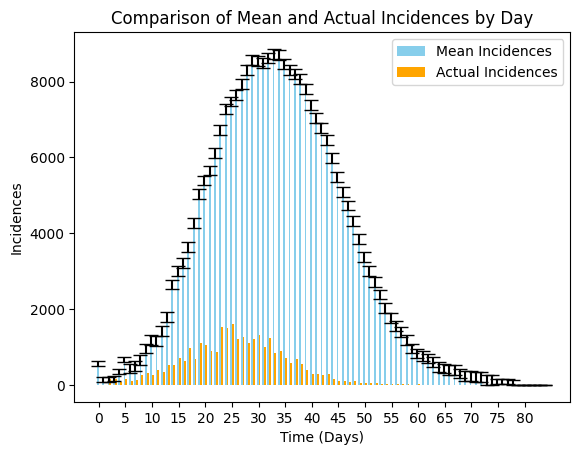

In [125]:
data = {
    'Day': list(range(max(time_sample) + 1)),
    'MeanIncidences': incidences,
    'StdError': incidences_std,  # Example standard errors for each day
    'ActualIncidences': incidences_true[:max(time_sample) + 1]  # Actual incidences for each day
}
df_plot = pd.DataFrame(data)
ci = 1.96 * df_plot['StdError']  # 95% confidence interval

# Parameters for plotting
bar_width = 0.35  # Width of the bars
days = np.arange(len(df_plot['Day']))  # Day numbers for plotting

# Plot mean incidences with CI as error bars
plt.bar(days - bar_width/2, df_plot['MeanIncidences'], width=bar_width, color='skyblue', yerr=ci, capsize=5, label='Mean Incidences')

# Plot actual incidences
plt.bar(days + bar_width/2, df_plot['ActualIncidences'], width=bar_width, color='orange', label='Actual Incidences')

# Adding details
plt.xlabel('Time (Days)')
plt.ylabel('Incidences')
plt.title('Comparison of Mean and Actual Incidences by Day')
plt.xticks(ticks=days[::5], labels=df_plot['Day'][::5])  # Adjust as needed
plt.legend()

# Display the plot
plt.show()


In [126]:
# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(max(time_sample) + 1),
        'Incidence Number': incidences
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

# Transform our true incidence data into pandas dataframes
inc_data_true = pd.DataFrame(
    {
        'Time': np.arange(max(time_sample) + 1),
        'Incidence Number': incidences_true[:max(time_sample) + 1]
    }
)

inference_true = branchpro.BranchProPosterior(
    inc_data=inc_data_true,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference_true.run_inference(tau=tau)
intervals_true = inference_true.get_intervals(central_prob=.95)

fig = ReproductionNumberPlot()

fig.add_interval_true_rt(intervals_true)
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



### Progress Summary

In [ ]:
# 0. Calculate the true incidences of the population
# Now the goal is to predict the incidences correctly
# But a problem occured, the incidence data is much larger if using original model
# 1. Change the Omega, which will make much more sense
# 2. Debug the compiling model code
# 3. Change the model by deleting the normalisation and sigma prior part
# Problem 1: How to set a range of sigma to pick for the model? - The sigma should not be a large value, which should usually take values about 0.0001 to 0.001
# Also, I think it would be better first scale up the Theda and I in the model, and then rescale it back. The reason is that this 0.001 seems to approach the precision of pystan
# Problem 2: How to set a resonable Omega? - This must be related with the recovery period, have calculated the mean recovery period

In [135]:
# This correspond to 3 and problem 1
poisson_model = """
functions {
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aOmega) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aOmega));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aOmega[(S-t+2):]));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length omega
    array [N] real Theta; // local prevalence for N days
    array [S] real revOmega; // reversed PCR positive probability
}
parameters {
    array [N] real<lower=0> I; // local incidence for N days
    real<lower=0> sigma; // variance of the log-normal distribution
}
model {
    for(t in 1:N) {
        if (effective_no_infectives(N, S, t, I, revOmega) != 0) {
            Theta[t] ~ normal (
                effective_no_infectives(
                    N, S, t, I, revOmega), sigma); // likelihood
                }
    }
    sigma ~ uniform(0, 1); // prior of sigma
}
"""
poisson_data = {
    'N': max(time_sample) + 1,
    'S': len(omega),
    'Theta': y_interpolated, #  change to frequency
    'tau': tau,
    'revOmega': omega[::-1]}

In [136]:
# Correspond to 2
posterior = stan.build(poisson_model, data=poisson_data, random_seed=10)
fit = posterior.sample(num_chains=3, num_samples=1000)

# Assuming time_sample correctly indexes the days for 'I' and 'Theta'
samples = az.from_pystan(
    posterior=fit,
    observed_data='Theta',  # Use 'Theta' as the observed data
    coords={'observation': list(range(max(time_sample) + 1))},  # 'covariate' removed
    dims={'Theta': ['observation'], 'I': ['observation']}  # Adjusted dims
)
df = az.summary(samples)
df

Building...

In file included from /Users/yunliqi/Library/Caches/httpstan/4.10.1/models/7bvwv4yu/model_7bvwv4yu.cpp:2:
In file included from /Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4:
In file included from /Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:23:
In file included from /Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/httpstan/include/Eigen/Sparse:26:
In file included from /Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/httpstan/include/Eigen/SparseCore:61:
/Users/yunliqi/mambaforge/envs/limited-resources/li

62 warnings generated.
ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: object file (/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/httpstan/stan_services.o) was built for newer macOS version (14.0) than being linked (11.0)
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-11.0-arm64-cpython-311/Users/yunliqi/Library/Caches/httpstan/4.10.1/models/7bvwv4yu/model_7bvwv4yu.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],2.362,2.455,0.195,5.802,1.412,1.114,3.0,14.0,2.92
I[1],0.871,0.797,0.139,1.982,0.458,0.362,4.0,17.0,2.76
I[2],1.916,1.517,0.574,4.055,0.872,0.688,3.0,11.0,3.76
I[3],2.961,2.439,0.506,6.299,1.403,1.107,3.0,16.0,2.82
I[4],0.822,0.901,0.178,2.098,0.518,0.409,4.0,25.0,2.41
...,...,...,...,...,...,...,...,...,...
I[81],1.201,1.101,0.136,2.722,0.633,0.500,4.0,12.0,2.77
I[82],0.622,0.331,0.173,0.961,0.190,0.150,4.0,15.0,2.74
I[83],1.018,0.566,0.518,1.814,0.325,0.257,4.0,14.0,2.86
I[84],1.774,2.035,0.312,4.659,1.170,0.924,4.0,11.0,2.74


In [129]:
# Summary of the inference result
incidences = df['mean'].values * len(demo_data)
incidences[-1] = 0
incidences_std = df['sd'].values * len(demo_data)
incidences_std[-1] = 1
df.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],0.004,0.000,0.003,0.004,0.0,0.0,62.0,77.0,1.03
I[1],0.001,0.001,0.000,0.002,0.0,0.0,20.0,93.0,1.11
I[2],0.001,0.000,0.000,0.002,0.0,0.0,36.0,16.0,1.05
I[3],0.001,0.001,0.000,0.002,0.0,0.0,30.0,47.0,1.11
I[4],0.002,0.001,0.001,0.004,0.0,0.0,61.0,126.0,1.04


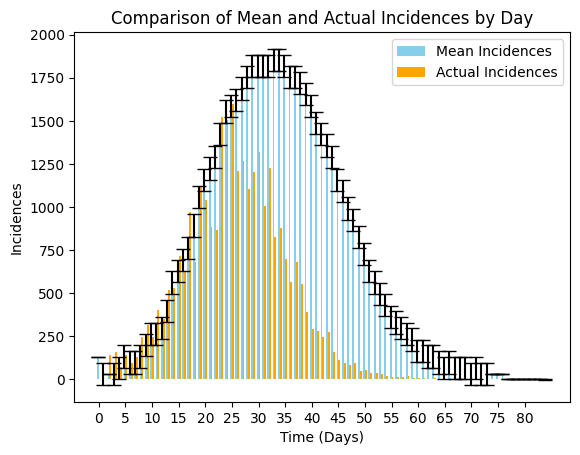

In [130]:
# Correspond to problem 1
data = {
    'Day': list(range(max(time_sample) + 1)),
    'MeanIncidences': incidences,
    'StdError': incidences_std,  # Example standard errors for each day
    'ActualIncidences': incidences_true[:max(time_sample) + 1]  # Actual incidences for each day
}
df_plot = pd.DataFrame(data)
ci = 1.96 * df_plot['StdError']  # 95% confidence interval

# Parameters for plotting
bar_width = 0.35  # Width of the bars
days = np.arange(len(df_plot['Day']))  # Day numbers for plotting

# Plot mean incidences with CI as error bars
plt.bar(days - bar_width/2, df_plot['MeanIncidences'], width=bar_width, color='skyblue', yerr=ci, capsize=5, label='Mean Incidences')

# Plot actual incidences
plt.bar(days + bar_width/2, df_plot['ActualIncidences'], width=bar_width, color='orange', label='Actual Incidences')

# Adding details
plt.xlabel('Time (Days)')
plt.ylabel('Incidences')
plt.title('Comparison of Mean and Actual Incidences by Day')
plt.xticks(ticks=days[::5], labels=df_plot['Day'][::5])  # Adjust as needed
plt.legend()

# Display the plot
plt.show()


14.03676320965882


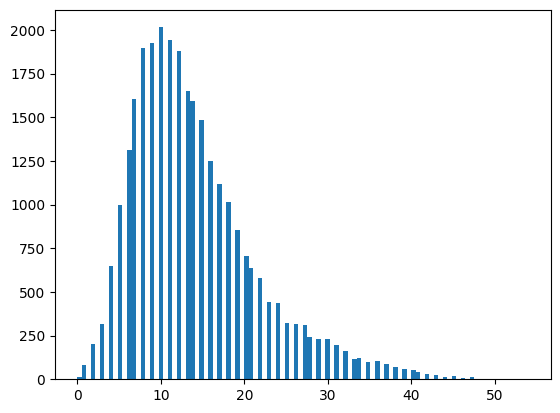

In [132]:
# Calculate the mean recovery time, correspond to problem 2
last_row = time_data.iloc[-1, :]
last_time = time_data.iloc[-1, 0]
element_recovered = []
for i in range(len(last_row)):
    if last_row[i] == 9:
        element_recovered.append(i)
recovery_times = []
for i in element_recovered:
    time = int(last_time)
    while time_data.iloc[time, i] == 9:
        time -= 1
    recovered_time = time + 1
    while time_data.iloc[time, i] > 1:
        if time == 0:
            time = -1
            break
        time -= 1
    infected_time = time + 1
    recovery_times.append(recovered_time - infected_time)
mean_recovery_time = np.mean(recovery_times)
print(mean_recovery_time)
plt.hist(recovery_times, bins=100)
plt.show()

In [134]:
# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(max(time_sample) + 1),
        'Incidence Number': incidences
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

# Transform our true incidence data into pandas dataframes
inc_data_true = pd.DataFrame(
    {
        'Time': np.arange(max(time_sample) + 1),
        'Incidence Number': incidences_true[:max(time_sample) + 1]
    }
)

inference_true = branchpro.BranchProPosterior(
    inc_data=inc_data_true,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference_true.run_inference(tau=tau)
intervals_true = inference_true.get_intervals(central_prob=.95)

fig = ReproductionNumberPlot()

fig.add_interval_true_rt(intervals_true)
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



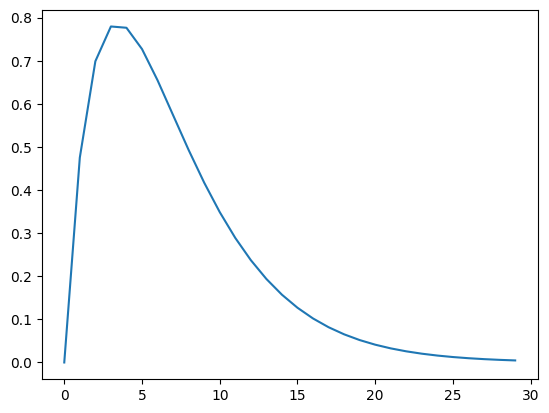

In [9]:
ws_mean = 7
ws_var = 5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(30))
omega = disc_w * 7.5
plt.plot(omega)

In [35]:
# This correspond to 3 and problem 1
poisson_model = """
functions {
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aOmega) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aOmega));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aOmega[(S-t+2):]));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length omega
    array [N] real Theta; // local prevalence for N days
    array [S] real revOmega; // reversed PCR positive probability
}
parameters {
    array [N] real<lower=0> I; // local incidence for N days
    real<lower=0> sigma; // variance of the log-normal distribution
}
model {
    for(t in 1:N) {
        Theta[t] ~ normal (
            effective_no_infectives(
                N, S, t, I, revOmega), sigma); // likelihood
    }
    sigma ~ normal(0, 1); // prior of sigma
    for(t in 1:N) {
        I[t] ~ uniform(0, 10000); // prior of I
    }
}
"""
poisson_data = {
    'N': max(time_sample) + 1,
    'S': len(omega),
    'Theta': y_interpolated * len(demo_data), #  change to frequency
    'revOmega': omega[::-1]}

In [36]:
# Correspond to 2
posterior = stan.build(poisson_model, data=poisson_data)
fit = posterior.sample(num_chains=3, num_samples=1000)

# Assuming time_sample correctly indexes the days for 'I' and 'Theta'
samples = az.from_pystan(
    posterior=fit,
    observed_data='Theta',  # Use 'Theta' as the observed data
    coords={'observation': list(range(max(time_sample) + 1))},  # 'covariate' removed
    dims={'Theta': ['observation'], 'I': ['observation']}  # Adjusted dims
)
df = az.summary(samples)
df

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_v3w1wklw/model_7kkvznu4.stan', line 35, column 26: Argument
    10000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:  12% (700/6000)
Sampling:  45% (2700/6000)
Sampling:  78% (4700/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000147 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.47 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is nan, but must be finite! (in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_6fn1isun/model_7kkvznu4.stan', line 29, column 8 to line 31, column 46)
 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],1.867,1.664,0.122,4.117,0.957,0.756,3.0,12.0,3.70
I[1],0.770,0.670,0.096,1.686,0.385,0.304,4.0,14.0,2.78
I[2],5.808,6.506,0.171,14.942,3.741,2.953,3.0,12.0,2.85
I[3],3.002,3.251,0.644,7.622,1.870,1.476,3.0,11.0,2.88
I[4],1.510,0.839,0.348,2.307,0.483,0.381,4.0,11.0,2.62
...,...,...,...,...,...,...,...,...,...
I[81],0.595,0.318,0.185,0.961,0.183,0.144,4.0,15.0,2.67
I[82],5.312,3.794,0.108,9.093,2.182,1.722,3.0,11.0,2.87
I[83],1.054,0.724,0.365,2.058,0.416,0.328,3.0,11.0,3.31
I[84],2.658,2.576,0.466,6.285,1.481,1.169,4.0,18.0,2.82


array([[<Axes: title={'center': 'I'}>, <Axes: title={'center': 'I'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

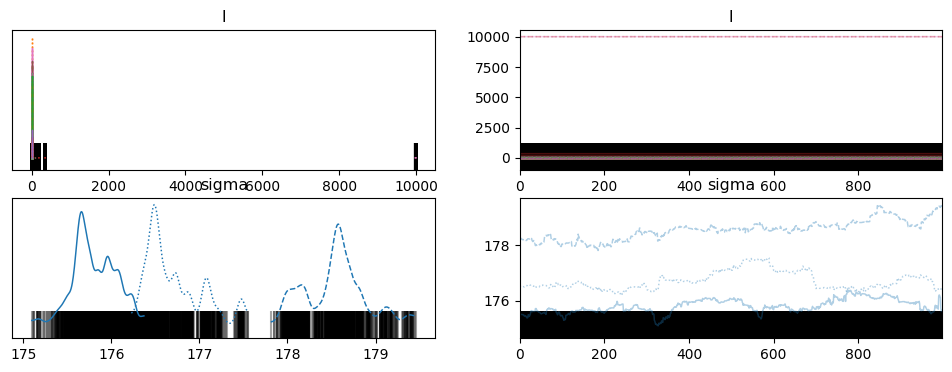

In [37]:
az.plot_trace(samples)

/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (86) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'I\n0'}>,
        <Axes: title={'center': 'I\n1'}>,
        <Axes: title={'center': 'I\n2'}>,
        <Axes: title={'center': 'I\n3'}>],
       [<Axes: title={'center': 'I\n4'}>,
        <Axes: title={'center': 'I\n5'}>,
        <Axes: title={'center': 'I\n6'}>,
        <Axes: title={'center': 'I\n7'}>],
       [<Axes: title={'center': 'I\n8'}>,
        <Axes: title={'center': 'I\n9'}>,
        <Axes: title={'center': 'I\n10'}>,
        <Axes: title={'center': 'I\n11'}>],
       [<Axes: title={'center': 'I\n12'}>,
        <Axes: title={'center': 'I\n13'}>,
        <Axes: title={'center': 'I\n14'}>,
        <Axes: title={'center': 'I\n15'}>],
       [<Axes: title={'center': 'I\n16'}>,
        <Axes: title={'center': 'I\n17'}>,
        <Axes: title={'center': 'I\n18'}>,
        <Axes: title={'center': 'I\n19'}>],
       [<Axes: title={'center': 'I\n20'}>,
        <Axes: title={'center': 'I\n21'}>,
        <Axes: title={'center': 'I\n22'}>,
        <Axes: t

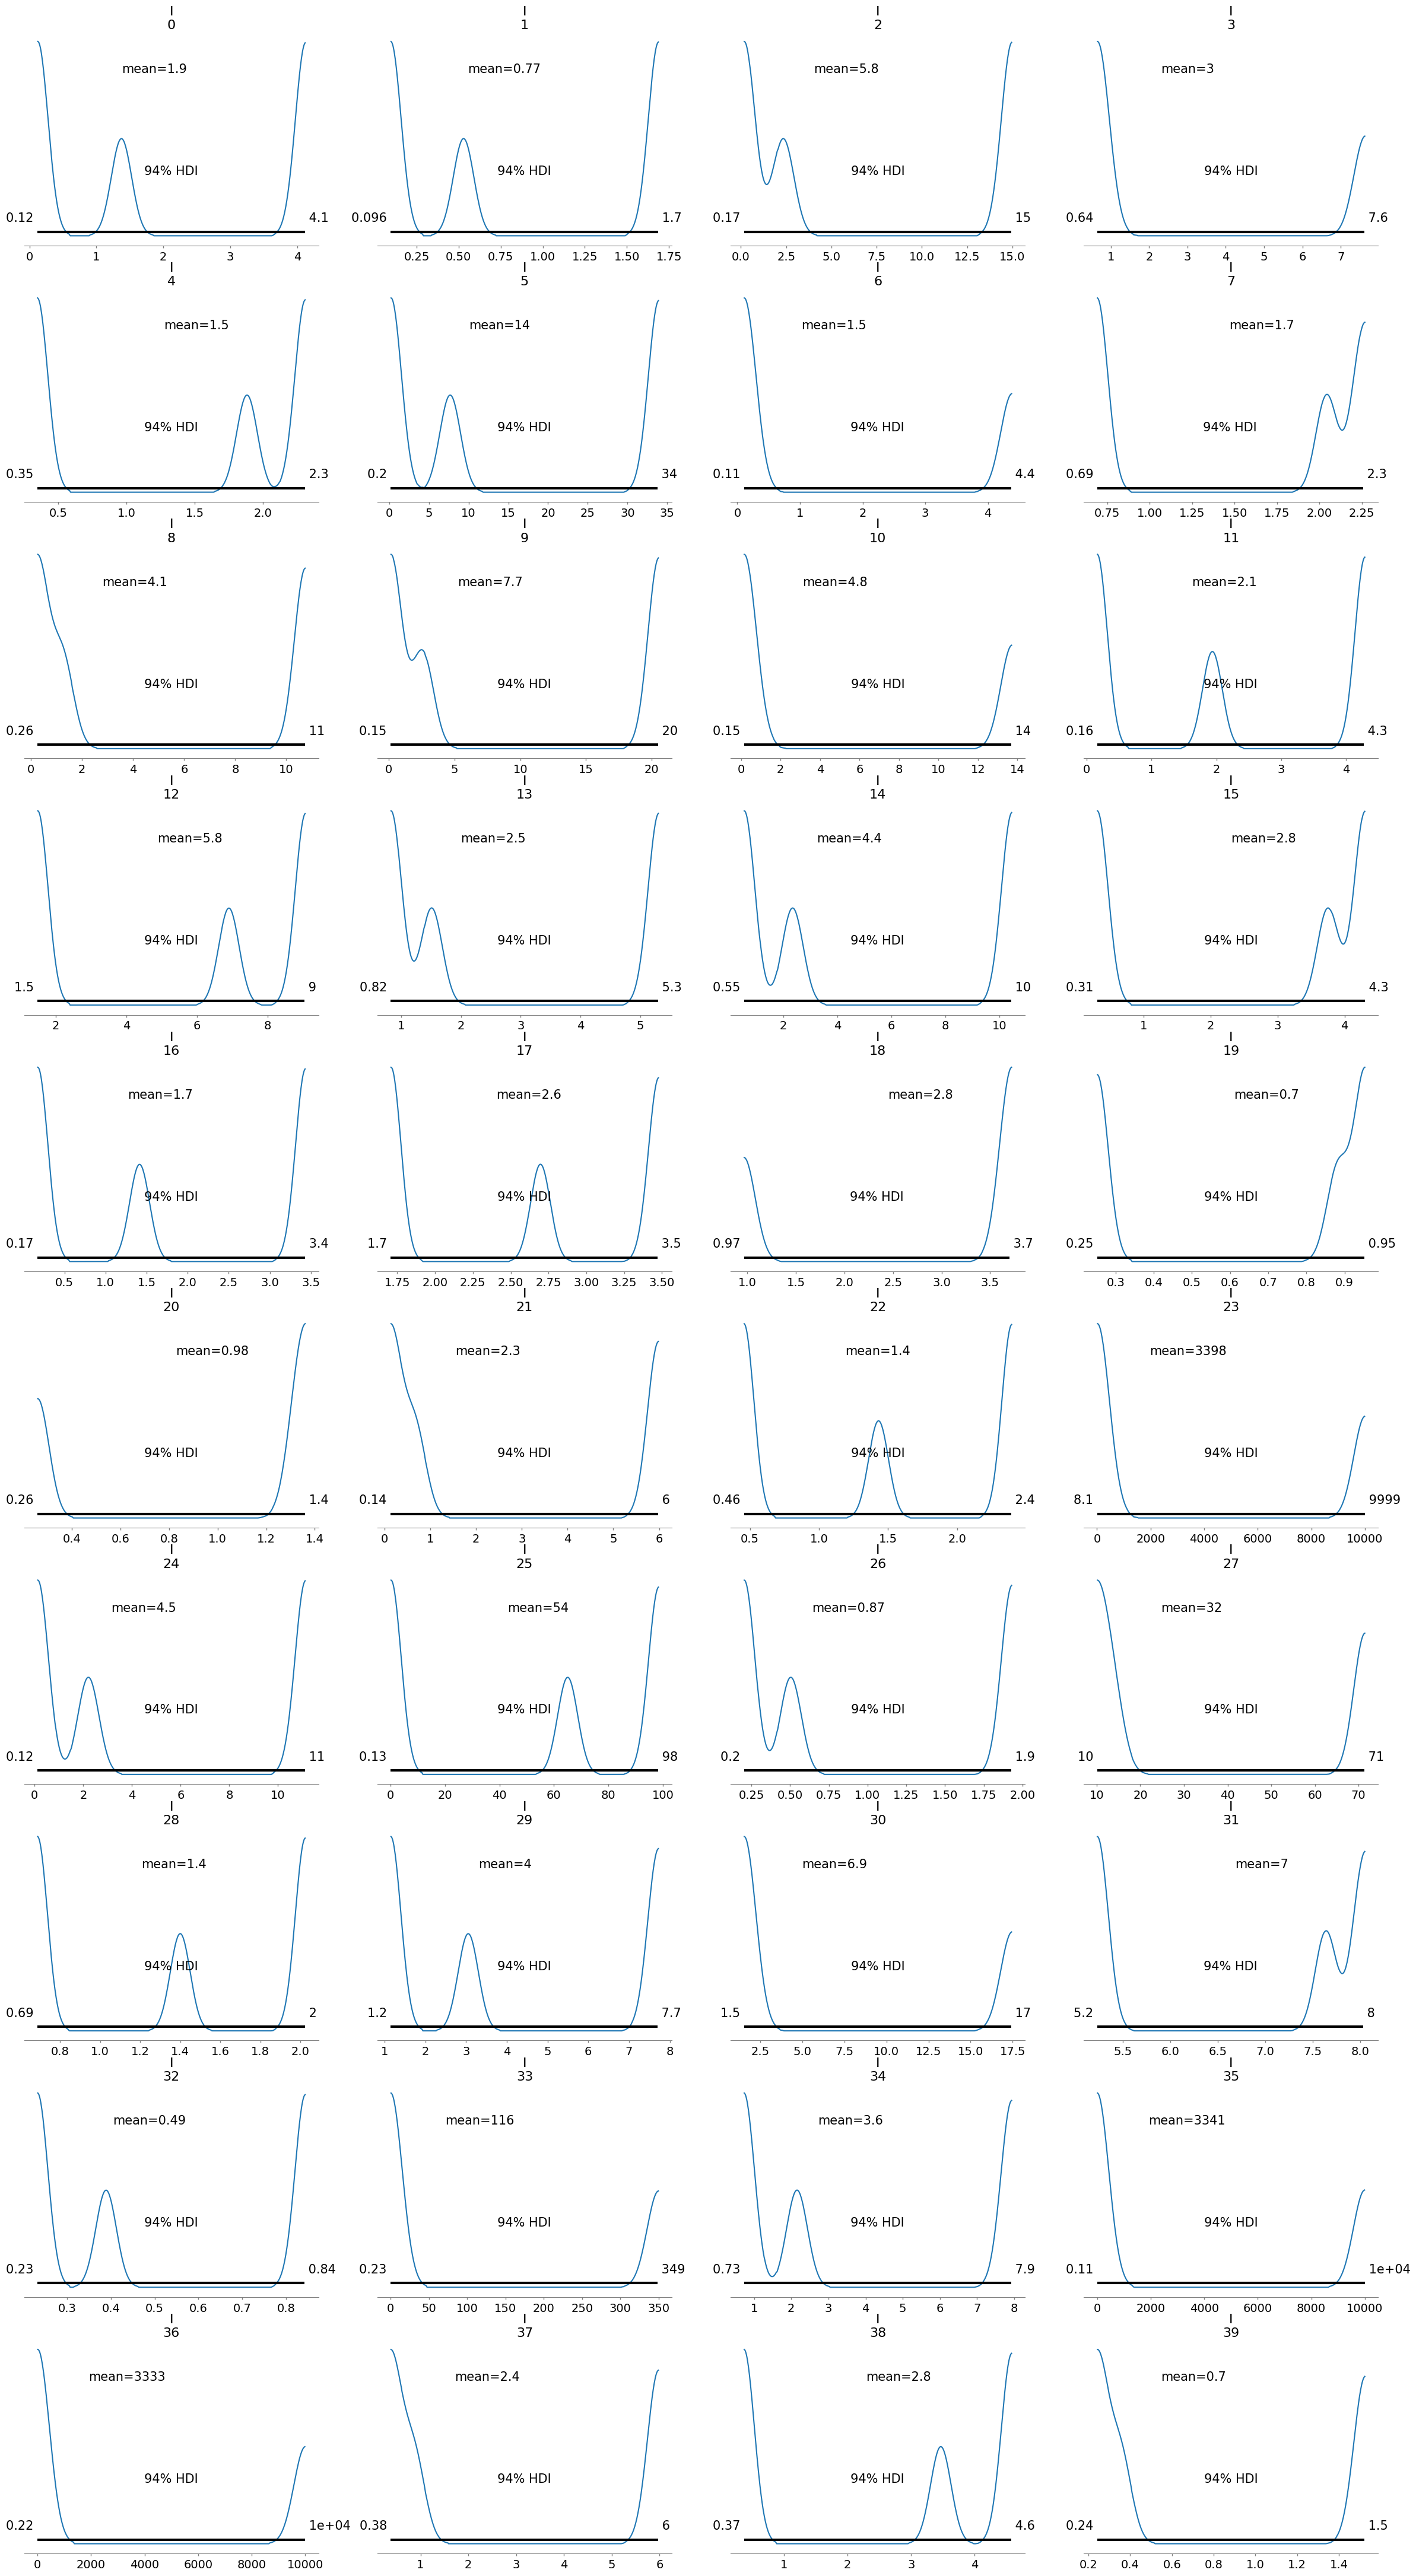

In [38]:
az.plot_posterior(samples)

In [39]:
df['r_hat'].values

array([3.7 , 2.78, 2.85, 2.88, 2.62, 3.45, 2.7 , 2.81, 2.95, 2.54, 2.88,
       2.42, 2.71, 2.59, 3.17, 2.46, 2.87, 2.4 , 2.86, 2.63, 2.81, 3.18,
       2.84, 2.4 , 3.35, 2.67, 3.44, 3.43, 2.87, 3.47, 2.86, 2.9 , 3.21,
       2.69, 3.43, 2.65, 2.49, 3.09, 2.73, 3.59, 2.98, 3.46, 2.83, 3.31,
       3.55, 3.16, 2.93, 3.05, 2.79, 2.74, 3.15, 2.89, 2.93, 3.19, 3.45,
       3.4 , 3.  , 2.57, 2.51, 2.53, 2.7 , 2.8 , 3.35, 2.99, 2.67, 2.62,
       3.19, 3.27, 2.1 , 2.79, 3.69, 3.48, 2.85, 3.5 , 2.57, 2.87, 3.3 ,
       3.51, 3.35, 2.63, 2.48, 2.67, 2.87, 3.31, 2.82, 2.83])

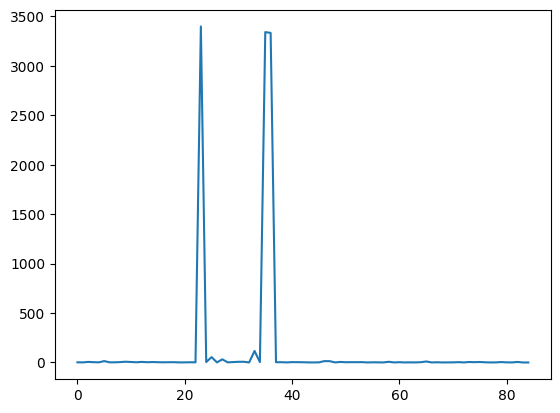

In [40]:
# Summary of the inference result
incidences = df['mean'].values[:-1] 
incidences_std = df['sd'].values[:-1]
incidences[-1] = 0
incidences_std[-1] = 1
incidences[-2] = 0
incidences_std[-2] = 1
plt.plot(incidences)

In [191]:
df_to_save = pd.DataFrame({'mean': incidences})
df_to_save.to_csv('incidences.csv', index=False)

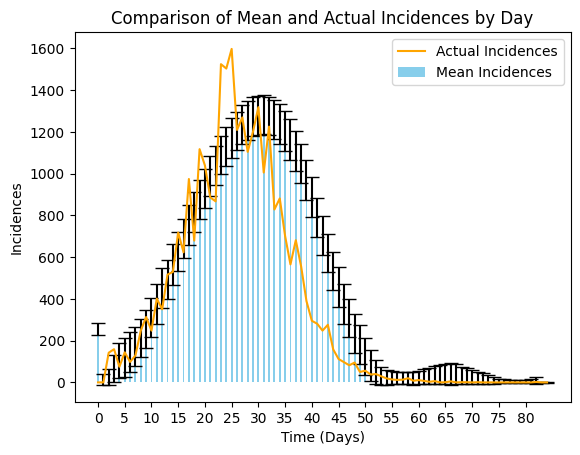

In [25]:
# Correspond to problem 1
data = {
    'Day': list(range(max(time_sample) + 1)),
    'MeanIncidences': incidences,
    'StdError': incidences_std,  # Example standard errors for each day
    'ActualIncidences': incidences_true[:max(time_sample) + 1]  # Actual incidences for each day
}
df_plot = pd.DataFrame(data)
ci = 1.96 * df_plot['StdError']  # 95% confidence interval

# Parameters for plotting
bar_width = 0.35  # Width of the bars
days = np.arange(len(df_plot['Day']))  # Day numbers for plotting

# Plot mean incidences with CI as error bars
plt.bar(days, df_plot['MeanIncidences'], width=bar_width, color='skyblue', yerr=ci, capsize=5, label='Mean Incidences')

# Plot actual incidences
plt.plot(days, df_plot['ActualIncidences'], color='orange', label='Actual Incidences')

# Adding details
plt.xlabel('Time (Days)')
plt.ylabel('Incidences')
plt.title('Comparison of Mean and Actual Incidences by Day')
plt.xticks(ticks=days[::5], labels=df_plot['Day'][::5])  # Adjust as needed
plt.legend()

# Display the plot
plt.show()


In [183]:
df_to_save = pd.DataFrame({'time': range(max(time_sample) + 1), 'y_interpolated': y_interpolated * len(demo_data)})
df_to_save.to_csv('y_interpolated.csv', index=False)
df_to_save = pd.DataFrame({'omega': omega})
df_to_save.to_csv('omega.csv', index=False)

In [41]:
# This correspond to 3 and problem 1
poisson_model = """
functions {
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aOmega) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aOmega));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aOmega[(S-t+2):]));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length omega
    array [N] real Theta; // local prevalence for N days
    array [S] real revOmega; // reversed PCR positive probability
}
parameters {
    array [N] real<lower=0> I; // local incidence for N days
    real<lower=0> sigma; // variance of the log-normal distribution
}
model {
    for(t in 1:N) {
        Theta[t] ~ normal (
            effective_no_infectives(
                N, S, t, I, revOmega), sigma); // likelihood
    }
    sigma ~ normal(0, 1); // prior of sigma
    for(t in 1:N) {
        I[t] ~ normal(5000, 1700); // prior of I
    }
}
"""
poisson_data = {
    'N': max(time_sample) + 1,
    'S': len(omega),
    'Theta': y_interpolated * len(demo_data), #  change to frequency
    'revOmega': omega[::-1]}

In [42]:
# Correspond to 2
posterior = stan.build(poisson_model, data=poisson_data)
fit = posterior.sample(num_chains=3, num_samples=1000)

# Assuming time_sample correctly indexes the days for 'I' and 'Theta'
samples = az.from_pystan(
    posterior=fit,
    observed_data='Theta',  # Use 'Theta' as the observed data
    coords={'observation': list(range(max(time_sample) + 1))},  # 'covariate' removed
    dims={'Theta': ['observation'], 'I': ['observation']}  # Adjusted dims
)
df = az.summary(samples)
df

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_ajyjh4r1/model_5mqtjwiv.stan', line 35, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_ajyjh4r1/model_5mqtjwiv.stan', line 35, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],256.306,14.284,229.335,281.754,0.226,0.160,4152.0,2448.0,1.0
I[1],14.086,12.492,0.002,37.333,0.222,0.168,2375.0,1500.0,1.0
I[2],25.879,19.371,0.013,60.899,0.327,0.241,2629.0,1380.0,1.0
I[3],68.011,33.441,4.984,126.303,0.683,0.483,2200.0,1458.0,1.0
I[4],105.413,43.376,26.596,187.561,0.947,0.670,1974.0,1294.0,1.0
...,...,...,...,...,...,...,...,...,...
I[81],5.043,4.698,0.006,13.916,0.061,0.056,3737.0,1376.0,1.0
I[82],9.620,8.720,0.006,26.266,0.123,0.103,3161.0,1503.0,1.0
I[83],5004.473,1659.932,1935.448,8049.453,32.787,23.186,2559.0,1183.0,1.0
I[84],4994.005,1694.404,1727.598,8121.438,31.390,22.199,2898.0,1270.0,1.0


In [82]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,I.1,I.2,I.3,...,I.77,I.78,I.79,I.80,I.81,I.82,I.83,I.84,I.85,sigma
draws,,,,,,,,,,,,,,,,,,,,,
0,-303.090027,0.990348,0.030432,7.0,127.0,0.0,352.835031,251.355593,1.266776,47.360245,...,1.446645,1.071131,6.770746,1.242282,1.717939,3.960087,37.899242,4791.672340,4825.515266,12.602823
1,-302.116679,0.998761,0.033957,7.0,127.0,0.0,351.406702,251.342253,15.724579,4.027065,...,0.223982,4.432804,12.967235,2.065620,5.485630,11.210059,1.847004,6823.420797,9962.140653,12.733810
2,-305.386317,0.963815,0.030585,7.0,127.0,0.0,349.234103,238.350198,18.296874,38.101650,...,6.108475,0.558350,15.128988,5.395796,6.277801,7.932114,12.603083,4864.039012,6532.899362,12.934317
3,-301.271858,0.849251,0.030432,7.0,127.0,0.0,351.458090,273.222785,7.001878,25.263766,...,4.962853,1.038394,2.392586,6.026478,7.016746,5.578056,1.584697,6483.653733,3962.445106,12.436849
4,-302.474019,0.866800,0.033957,7.0,127.0,0.0,341.137616,262.576278,20.759557,4.647520,...,0.137995,0.182117,0.531548,6.074454,0.971256,3.761051,16.004334,5167.379065,2310.398814,12.123146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-288.480722,0.989899,0.033957,7.0,127.0,0.0,332.041379,262.510322,5.162819,18.246188,...,6.120841,2.170268,3.393199,8.654963,4.694621,0.040632,14.286277,6879.635614,4417.964529,11.476439
2996,-290.915930,0.945278,0.030585,7.0,127.0,0.0,333.420949,261.340678,5.598872,39.587907,...,12.456027,0.618893,2.052763,0.797652,16.004336,5.725424,1.674301,6538.190288,3781.093788,11.814477
2997,-296.885940,0.868493,0.030432,7.0,127.0,0.0,339.866359,241.015183,22.270011,19.844472,...,10.235607,0.231977,3.937643,7.475227,0.344563,4.802336,4.501659,4748.631855,5653.811449,12.259911


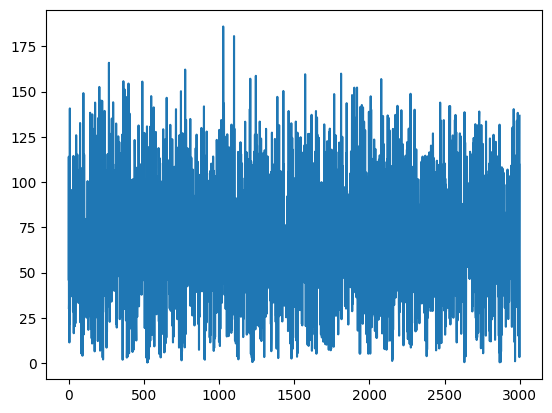

In [81]:
plt.plot(fit.to_frame()['I.4'].values)